## Difference-in-Differences (DiD) Analysis

Having confirmed (or adjusted for) parallel pre-trends, we now estimate the **treatment effect** of the expulsion initiative using two levels of aggregation:
1. **Nationwide** (Swiss vs. Foreigners, aggregated 2009–2024)  
2. **Canton-panel** (26 cantons × 2 groups × years)

In [19]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.regressionplots import influence_plot

### 1. Nationwide DiD with Group & Year Fixed Effects

To control for average differences across groups and over time, we estimate:

$\text{crime\_rate}_{gt}
=
\beta\,(T_{g}\times P_{t})
\;+\;\underbrace{\gamma_{g}}_{\text{group FE}}
\;+\;\underbrace{\lambda_{t}}_{\text{year FE}}
\;+\;\varepsilon_{gt}.$
- This absorbs any group-specific level and common time shocks.
- We still interpret the $T\times P$ coefficient as the causal effect.

This regression is conducted on the nationwide dataset

In [20]:
#2) Nationwide aggregated DiD w fixed effects
df_agg = pd.read_excel('/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned.xlsx')
df_agg['T'] = (df_agg['group']=="Foreigner").astype(int)
df_agg['P'] = (df_agg['year']>=2017).astype(int)
model = smf.ols("crime_rate_per_100k ~ T:P + C(group) + C(year)", data=df_agg).fit()
print("Nationwide DiD (w/ Fixed Effects)")
print(model.summary())

Nationwide DiD (w/ Fixed Effects)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.988
Model:                             OLS   Adj. R-squared:                  0.973
Method:                  Least Squares   F-statistic:                     66.85
Date:                 Mon, 26 May 2025   Prob (F-statistic):           3.25e-09
Time:                         14:22:41   Log-Likelihood:                -97.478
No. Observations:                   28   AIC:                             227.0
Df Residuals:                       12   BIC:                             248.3
Df Model:                           15                                         
Covariance Type:             nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### 2. Canton-Panel DiD (Simple)

Using the canton-level panel (only cantons with ≥6 valid pre/post obs):

$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt}.$

- $c$ indexes cantons.  
- We cluster standard errors at the **canton** level.

This regression is conducted on the canton-specific dataset

In [21]:
# 3) Canton-panel DiD -----------------------------------------
df_ct = pd.read_excel("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/Data/cleaned/crimes_subject_to_law_cleaned_by_canton.xlsx")

good = []
for c in df_ct['canton'].unique():
    sub = df_ct[df_ct['canton']==c]
    good.append(c)
df_ct = df_ct[df_ct['canton'].isin(good)].copy()

# prepare DiD variables
df_ct = df_ct[df_ct['crime_rate_per_100k']>0]
df_ct['log_rate'] = np.log(df_ct['crime_rate_per_100k'])
df_ct['T'] = (df_ct['group']=="Foreigner").astype(int)
df_ct['P'] = (df_ct['year']>=2017).astype(int)
df_ct['T_P'] = df_ct['T'] * df_ct['P']
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['T'] * df_ct['t']

# 3a) Simple canton panel DiD
mod1 = smf.ols("crime_rate_per_100k ~ T_P + C(canton) + C(year) + C(group)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (simple)")
print(mod1.summary())


Canton-panel DiD (simple)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     97.69
Date:                 Mon, 26 May 2025   Prob (F-statistic):           1.36e-16
Time:                         14:22:41   Log-Likelihood:                -2817.3
No. Observations:                  556   AIC:                             5711.
Df Residuals:                      518   BIC:                             5875.
Df Model:                           37                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


### 4. Augmented Canton-Panel DiD (with Group-Specific Trend)

To soak up any residual slope differences, we add a group‐specific time trend:

$\text{crime\_rate}_{cgt} = 
\beta\,(T_{g}\times P_{t})
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

where $t$ is a **linear time index** (year–min(year)).

This regression is conducted on the canton-specific dataset

In [22]:
# 3b) Augmented with group‐specific trend
mod2 = smf.ols("crime_rate_per_100k ~ T_P + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     97.69
Date:                 Mon, 26 May 2025   Prob (F-statistic):           1.36e-16
Time:                         14:22:41   Log-Likelihood:                -2817.3
No. Observations:                  556   AIC:                             5711.
Df Residuals:                      518   BIC:                             5875.
Df Model:                           37                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 15
  warnings.warn('covariance of constraints does not have full '


$\text{crime\_rate}_{cgt}
= \beta\,(T_{g}\times P_{t})
\;+\;\theta\,(T_{g}\times t)
\;+\;FE_{c}
\;+\;FE_{t}
\;+\;FE_{g}
\;+\;\varepsilon_{cgt},$

In [23]:
# 3b) Augmented with group‐specific trend
mod2 = smf.ols("crime_rate_per_100k ~ T_P + T_t + C(group) + C(canton) + C(year)", data=df_ct).fit(cov_type='cluster', cov_kwds={'groups': df_ct['canton']})

print("\nCanton-panel DiD (with trend)")
print(mod2.summary())


Canton-panel DiD (with trend)
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     469.1
Date:                 Mon, 26 May 2025   Prob (F-statistic):           4.15e-24
Time:                         14:22:41   Log-Likelihood:                -2817.1
No. Observations:                  556   AIC:                             5712.
Df Residuals:                      517   BIC:                             5881.
Df Model:                           38                                         
Covariance Type:               cluster                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 38, but rank is 16
  warnings.warn('covariance of constraints does not have full '


### Canton-Specific DiD Regression Explanation

We estimate the following model:

$\text{crime\_rate}_{gct} = FE_{c}+FE_{t}+FE_{g}+ \sum_{c} \beta_c (T_g \cdot P_t \cdot \mathbb{1}\{\text{canton} = c\}) + \varepsilon_{gct}$

- **Outcome:** log of the crime rate for group $g$ (Swiss vs. foreigners), canton $c$, and year $t$.
- **$T_g \cdot P_t \cdot \mathbb{1}\{c = \text{canton}\}$:** canton-specific DiD effect, the treatment is interacted with post-period and canton identifiers, allowing the effect to vary by canton.

In [24]:
model = smf.ols("crime_rate_per_100k ~ C(group) + C(year) + C(canton) + C(canton):T_P", data=df_ct).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.813
Model:                             OLS   Adj. R-squared:                  0.791
Method:                  Least Squares   F-statistic:                     36.50
Date:                 Mon, 26 May 2025   Prob (F-statistic):          5.23e-145
Time:                         14:22:41   Log-Likelihood:                -2748.9
No. Observations:                  556   AIC:                             5618.
Df Residuals:                      496   BIC:                             5877.
Df Model:                           59                                         
Covariance Type:             nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

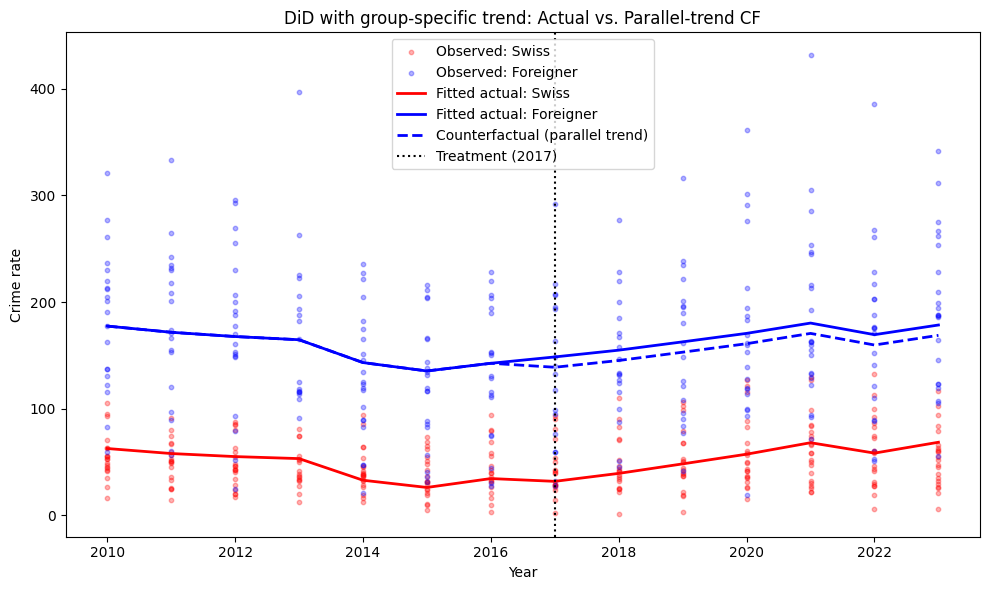

In [25]:
# Build a “counterfactual” dataset where Foreigner keeps its pre-treatment trend:
df_ct_cf = df_ct.copy()
# zero out the post dummy so the Foreigner×Post jump vanishes
df_ct_cf['T_P'] = 0

# keep the group‐specific trend term intact (so slope continues)
# T_t is just time × Foreigner, so it stays

# Predict both actual and counterfactual paths
df_ct['f_actual'] = mod2.predict(df_ct)
df_ct_cf['f_cf']    = mod2.predict(df_ct_cf)

# Aggregate to year × group means
agg = (
    df_ct
    .assign(f_cf=df_ct_cf['f_cf'])
    .groupby(['group','year'])
    .agg(obs_rate=('crime_rate_per_100k','mean'),
         fit_actual=('f_actual','mean'),
         fit_cf    =('f_cf','mean'))
    .reset_index()
)

plt.figure(figsize=(10,6))


for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = df_ct[df_ct['group'] == grp]
    plt.scatter(sub['year'], sub['crime_rate_per_100k'],
                color=color, alpha=0.3, s=10,
                label=f'Observed: {grp}')


for grp, color in [('Swiss','red'), ('Foreigner','blue')]:
    sub = agg[agg['group']==grp]
    plt.plot(sub['year'], sub['fit_actual'], color=color, lw=2,
             label=f'Fitted actual: {grp}')
    if grp=='Foreigner':
        plt.plot(sub['year'], sub['fit_cf'], color=color, lw=2, ls='--',
                 label='Counterfactual (parallel trend)')


plt.axvline(2017, color='black', ls=':', lw=1.5, label='Treatment (2017)')

plt.xlabel('Year')
plt.ylabel('Crime rate')
plt.title('DiD with group‐specific trend: Actual vs. Parallel‐trend CF')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/souhil/Desktop/Courses/Recherche Empirique/Final/did_graph.png", dpi=300, bbox_inches='tight')  
plt.show()

To determine if the linear specification is correct, we plotted the distribution of the errors, which looked relatively not skewed. Therefore we decided to stick to a lin-lin specification, but we still conducted the analysis on the a log-lin specification and the results were the same.

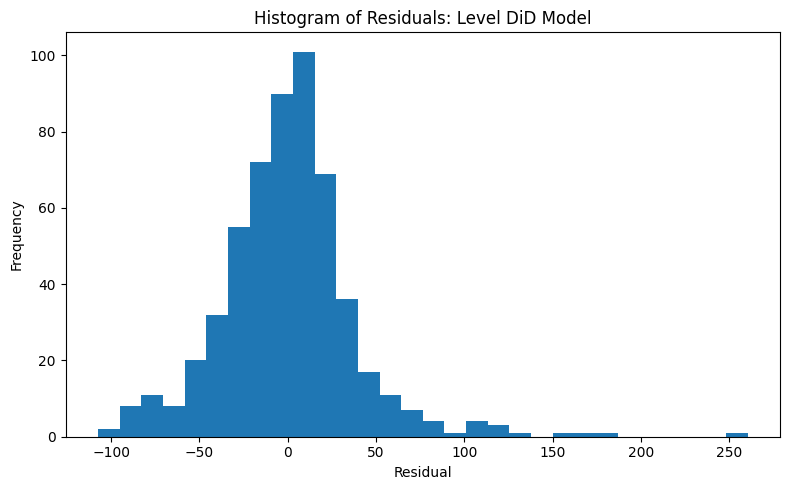

In [26]:
#Residual distribution
# Show a quick histogram of residuals for the level model—if they’re wildly skewed, that’s a strike for the log specification.
# -> residuals are normally distributed, most likely that linear specification is the correct one.

resid = mod2.resid

# Histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(resid, bins=30)
plt.title("Histogram of Residuals: Level DiD Model")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [27]:
# error unbiased from outliers because of heteroskedasticity
mod2_hc3 = mod2.get_robustcov_results(cov_type='HC3')
print(mod2_hc3.summary())

                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.761
Model:                             OLS   Adj. R-squared:                  0.743
Method:                  Least Squares   F-statistic:                     65.75
Date:                 Mon, 26 May 2025   Prob (F-statistic):          2.86e-172
Time:                         14:22:42   Log-Likelihood:                -2817.1
No. Observations:                  556   AIC:                             5712.
Df Residuals:                      517   BIC:                             5881.
Df Model:                           38                                         
Covariance Type:                   HC3                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

## After presentation, more tests

$$
\mathrm{CrimeRate}_{igt}
= \alpha
+ \sum_{i}\delta_{i}\,\mathbf{1}(\mathrm{canton}=i)
+ \sum_{t}\gamma_{t}\,\mathbf{1}(t)
+ \sum_{\substack{k=-5 \\ k\neq -1}}^{5}
    \beta_{k}\,\bigl[\mathbf{1}(t-2017 = k)\times D_{g}\bigr]
+ \varepsilon_{igt}
$$

In [28]:

df_ct = df_ct.copy()

# 1) Ensure year is int
df_ct['year'] = df_ct['year'].astype(int)

df_ct['treat'] = (df_ct['group'] == "Foreigner").astype(int)
print("Treated obs:", df_ct['treat'].sum(), "/", len(df_ct))

# 3) Build Patsy-safe leads/lags
lead_cols = []
for k in range(-5, 6):
    if k == -1: 
        continue
    suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
    name   = f"lead_{suffix}"
    df_ct[name] = ((df_ct['year'] - 2017) == k).astype(int) * df_ct['treat']
    print(f"{name}: {df_ct[name].sum()} treated obs")
    lead_cols.append(name)

# 4) Event-study regression
formula = "crime_rate_per_100k ~ " + " + ".join(lead_cols) + " + C(canton)+ C(group) + C(year)"
mod_es = smf.ols(formula, data=df_ct).fit(
    cov_type="cluster", cov_kwds={"groups": df_ct["canton"]}
)
print(mod_es.summary())

Treated obs: 278 / 556
lead_m5: 20 treated obs
lead_m4: 17 treated obs
lead_m3: 21 treated obs
lead_m2: 20 treated obs
lead_p0: 18 treated obs
lead_p1: 19 treated obs
lead_p2: 19 treated obs
lead_p3: 21 treated obs
lead_p4: 22 treated obs
lead_p5: 21 treated obs
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.768
Model:                             OLS   Adj. R-squared:                  0.747
Method:                  Least Squares   F-statistic:                     292.6
Date:                 Mon, 26 May 2025   Prob (F-statistic):           2.44e-22
Time:                         14:22:42   Log-Likelihood:                -2808.3
No. Observations:                  556   AIC:                             5711.
Df Residuals:                      509   BIC:                             5914.
Df Model:                           46                                         
Covariance Type: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 46, but rank is 22
  warnings.warn('covariance of constraints does not have full '


In [29]:

df_ct = df_ct.copy()

# 1) Ensure year is int
df_ct['year'] = df_ct['year'].astype(int)

df_ct['treat'] = (df_ct['group'] == "Foreigner").astype(int)
print("Treated obs:", df_ct['treat'].sum(), "/", len(df_ct))

# 3) Build Patsy-safe leads/lags
lead_cols = []
for k in range(-5, 6):
    if k == -1: 
        continue
    suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
    name   = f"lead_{suffix}"
    df_ct[name] = ((df_ct['year'] - 2017) == k).astype(int) * df_ct['treat']
    print(f"{name}: {df_ct[name].sum()} treated obs")
    lead_cols.append(name)

# 4) Event-study regression
df_ct['t'] = df_ct['year'] - df_ct['year'].min()
df_ct['T_t'] = df_ct['treat'] * df_ct['t']

# then in your formula add '+ T_t'
formula = "crime_rate_per_100k ~ " \
          + " + ".join(lead_cols) \
          + " + C(canton):t + C(group) + C(year)"
mod_es = smf.ols(formula, data=df_ct).fit(
    cov_type="cluster", cov_kwds={"groups": df_ct["canton"]}
)
print(mod_es.summary())

Treated obs: 278 / 556
lead_m5: 20 treated obs
lead_m4: 17 treated obs
lead_m3: 21 treated obs
lead_m2: 20 treated obs
lead_p0: 18 treated obs
lead_p1: 19 treated obs
lead_p2: 19 treated obs
lead_p3: 21 treated obs
lead_p4: 22 treated obs
lead_p5: 21 treated obs
                             OLS Regression Results                            
Dep. Variable:     crime_rate_per_100k   R-squared:                       0.748
Model:                             OLS   Adj. R-squared:                  0.725
Method:                  Least Squares   F-statistic:                     305.2
Date:                 Mon, 26 May 2025   Prob (F-statistic):           1.55e-22
Time:                         14:22:42   Log-Likelihood:                -2831.5
No. Observations:                  556   AIC:                             5757.
Df Residuals:                      509   BIC:                             5960.
Df Model:                           46                                         
Covariance Type: 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 22
  warnings.warn('covariance of constraints does not have full '
